# Workflow for n-artifact clusters

1. **additional artifacts**: 

(a) completely surrounded by artifacts --> artifacts themselves

(b) contiguous to an artifact (or artifact cluster?) and with an artifact index NEAR the artifact index for that city

2. Identify n-artifact clusters (clusters of contiguous artifacts, n>2); make sure that the union has no interior
3. For each cluster, drop all the interior lines and skeletonize
4. Visualize to see if it works

- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from scipy import sparse
import folium
import folium.plugins as plugins
import shapely

from core import algorithms, utils
from core.geometry import voronoi_skeleton

Specify case metadata

In [2]:
case = "Liège"

Read road data

In [3]:
roads = utils.read_parquet_roads(case)

Remove duplicated roads

In [4]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Assign COINS-based information to roads

In [5]:
# %%time
roads, coins = algorithms.common.continuity(roads)

Read **polygons**

In [6]:
fas = momepy.FaceArtifacts(roads)
polygons = fas.polygons.set_crs(roads.crs)

**Iteratively identify polygons that are fully enclosed by artifacts, or that touch artifacts and have a FAI in +1% of threshold, as artifacts**  

In [7]:
# rook neighbors
rook = graph.Graph.build_contiguity(polygons, rook=True)
polygons['neighbors'] = rook.neighbors
prop = 1.01

# polygons are not artifacts,
polygons["is_artifact"] = False
# unless the fai is below the threshold,
polygons.loc[polygons.face_artifact_index < fas.threshold, "is_artifact"] = True

# OR (iteratively)

while True:

    artifact_count_before = sum(polygons.is_artifact)

    # polygons that are enclosed by artifacts
    polygons["enclosed"] = polygons.apply(
        lambda x: len(x.neighbors)>0 and all(polygons.loc[list(x.neighbors), "is_artifact"]), 
        axis = 1
    )
    # setting is_artifact to True
    polygons.loc[polygons.enclosed, "is_artifact"] = True

    # polygons that are touching artifacts and within x% of fai
    polygons["touching"] = polygons.apply(
        lambda x: len(x.neighbors)>0 and any(polygons.loc[list(x.neighbors), "is_artifact"]), 
        axis = 1
    )

    # setting is_artifact to True
    polygons.loc[
        (polygons.touching == True) & (polygons.face_artifact_index < fas.threshold * prop),
        "is_artifact"
    ] = True

    artifact_count_after = sum(polygons.is_artifact)
    if artifact_count_after == artifact_count_before:
        break

In [8]:
print(artifact_count_after)

3662


In [9]:
# m = roads.explore(
#     "coins_len",
#     k=20,
#     scheme="quantiles",
#     tiles="cartodb positron",
#     prefer_canvas=True,
#     name="Roads",
#     highlight_kwds={"color": "red"},
#     style_kwds=dict(weight=5),
#     max_zoom=52,
#     opacity=0.5,
# )
# polygons[polygons.is_artifact].explore(m=m, name = "All artifacts", color = "red")
# polygons[polygons.face_artifact_index < fas.threshold].explore(m=m, name = "Initial artifacts", color = "green")
# #nodes.explore(m=m, name="Nodes", color="blue", marker_size=250)
# folium.LayerControl().add_to(m)
# plugins.MousePosition().add_to(m)

# m

**Get artifacts gdf**

In [10]:
artifacts = polygons[polygons.is_artifact][["geometry"]].copy()
artifacts["id"] = artifacts.index
artifacts.head()

,geometry,id
0,"POLYGON ((687053.642 5615820.989, 687059.393 5...",0
2,"POLYGON ((687053.642 5615820.989, 687051.723 5...",2
4,"POLYGON ((677400.757 5613704.998, 677429.096 5...",4
7,"POLYGON ((682353.554 5612410.841, 682350.603 5...",7
10,"POLYGON ((685360.558 5609766.62, 685359.515 56...",10


Remove edges fully within the artifact (dangles).

In [11]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Get nodes from the network.

In [12]:
nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(roads)), lines=False)

Link nodes to artifacts

In [13]:
node_idx, artifact_idx = artifacts.sindex.query(
    nodes.buffer(0.1), predicate="intersects"
)
intersects = sparse.coo_array(
    ([True] * len(node_idx), (node_idx, artifact_idx)),
    shape=(len(nodes), len(artifacts)),
    dtype=np.bool_,
)

Compute number of nodes per artifact

In [14]:
artifacts["node_count"] = intersects.sum(axis=0)

Apply additional filters to remove artifacts that are not suitable for simplification. These may be artifacts that:
- are too large in size
- are part of a larger intersection that may need different methods of simplification

In [15]:
area_threshold = 1250  # this is hard to determine but it can be done iteratively using different thresholds
circular_compactness_threshold = 0.15  # same as above

rook = graph.Graph.build_contiguity(artifacts, rook=True)

**keeping only size n>2 clusters!**

In [16]:
artifacts['comp'] = rook.component_labels
counts = artifacts['comp'].value_counts()
artifacts = artifacts.loc[artifacts['comp'].isin(counts[counts>2].index)].copy()

Compute number of stroke groups per artifact.

In [17]:
# def _get_stroke_info(artifacts, roads):
#     strokes = []
#     c_ = []
#     e_ = []
#     s_ = []
#     for geom in artifacts.geometry:
#         singles = 0
#         ends = 0
#         edges = roads.iloc[roads.sindex.query(geom, predicate="covers")]
#         if (  # roundabout special case
#             edges.coins_group.nunique() == 1
#             and edges.shape[0] == edges.coins_count.iloc[0]
#         ):
#             singles = 1
#             mains = 0
#         else:
#             all_ends = edges[edges.coins_end]
#             mains = edges[
#                 ~edges.coins_group.isin(all_ends.coins_group)
#             ].coins_group.nunique()

#             visited = []
#             for coins_count, group in zip(
#                 all_ends.coins_count, all_ends.coins_group, strict=True
#             ):
#                 if (group not in visited) and (
#                     coins_count == (edges.coins_group == group).sum()
#                 ):
#                     singles += 1
#                     visited.append(group)
#                 elif group not in visited:
#                     ends += 1
#                     # do not add to visited as they may be disjoint within the artifact
#         strokes.append(edges.coins_group.nunique())
#         c_.append(mains)
#         e_.append(ends)
#         s_.append(singles)
#     return strokes, c_, e_, s_


# strokes, c_, e_, s_ = _get_stroke_info(artifacts, roads)
# artifacts["stroke_count"] = strokes
# artifacts["C"] = c_
# artifacts["E"] = e_
# artifacts["S"] = s_

Filer artifacts caused by non-planar intersections.

In [18]:
# artifacts["non_planar"] = artifacts["stroke_count"] > artifacts["node_count"]
# a_idx, r_idx = roads.sindex.query(artifacts.geometry.boundary, predicate="overlaps")
# artifacts.iloc[np.unique(a_idx), -1] = True

**(not removing) the clusters that contain at least one non-planar component** (we will deal with them later, ...?)

In [19]:
# # non_planar_cluster: number of non-planar artifacts per cluster
# artifacts["non_planar_cluster"] = artifacts.apply(lambda x: sum(artifacts.loc[artifacts["comp"]==x.comp]["non_planar"]), axis = 1)
# # dealing with the non-planar later!
# artifacts = artifacts[artifacts.non_planar_cluster == 0].copy()

Count intersititial nodes (primes).

In [20]:
# artifacts["interstitial_nodes"] = artifacts.node_count - artifacts[["C", "E", "S"]].sum(
#     axis=1
# )

Define the type label.

In [21]:
# ces_type = []
# for x in artifacts[["node_count", "C", "E", "S"]].itertuples():
#     ces_type.append(f"{x.node_count}{'C' * x.C}{'E' * x.E}{'S' * x.S}")
# artifacts["ces_type"] = ces_type

In [22]:
artifacts.head()

,geometry,id,node_count,comp
2,"POLYGON ((687053.642 5615820.989, 687051.723 5...",2,8,0
12,"POLYGON ((681630.974 5612736.531, 681632.875 5...",12,5,5
13,"POLYGON ((681632.875 5612756.622, 681630.974 5...",13,4,5
15,"POLYGON ((684239.346 5610285.862, 684307.976 5...",15,6,5
16,"POLYGON ((684239.346 5610285.862, 684229.9 561...",16,2,5


**Skeletonization**

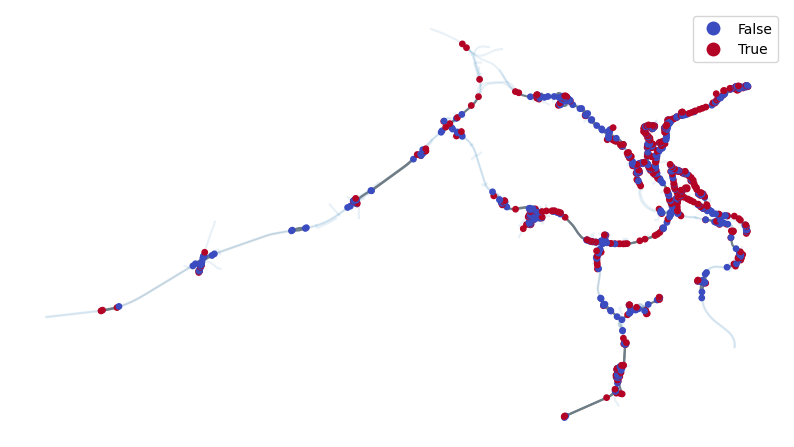

In [30]:
mycomp = 5

# get the cluster polygon
cluster_geom = artifacts[artifacts.comp == mycomp].union_all()

# find road segments WITHIN cluster polygon (to be dropped)
edges_outside = roads.iloc[roads.sindex.query(cluster_geom.boundary, predicate="covers")].copy()

# find road segments DELINEATING cluster polygon (to be partially merged, and kept)
edges_within = roads.iloc[roads.sindex.query(cluster_geom, predicate = "contains")].copy()

# find nodes ON the cluster polygon boundary (to be partially kept)
nodes_boundary = nodes.iloc[nodes.sindex.query(cluster_geom.boundary, predicate="intersects")].copy()

### determining which nodes to keep, by degree:
# count number of inner line road segments that intersect with each node
nodes_boundary["inner_line_count"] = nodes_boundary.geometry.apply(
    lambda x: len(edges_within.sindex.query(x, predicate="intersects"))
)
# count how many more edges are at that node (subtracting the x inner lines and the 2 from the boundary)
# if to_keep = 0 (i.e. degree is inner_lines + 2), this is an interstitial node and we want to drop it
# if to_keep >= 1 we want to keep it
nodes_boundary["to_keep"] = nodes_boundary.degree - nodes_boundary.inner_line_count - 2

# visualize to check if all is correct
fig, ax = plt.subplots(1,1, figsize = (10,10))
roads.iloc[roads.sindex.query(cluster_geom, predicate="intersects")].plot(ax=ax, alpha = .1)
artifacts[artifacts.comp == mycomp].plot(ax=ax, alpha = .1, zorder = 0)
edges_outside.plot(ax=ax, color = "grey", zorder = 1)
edges_within.plot(ax=ax, color = "grey", alpha = .1, zorder = 2)
nodes_boundary.to_keep = nodes_boundary.to_keep > 0
nodes_boundary.plot(ax=ax, column = "to_keep", zorder = 3, markersize = 15, cmap = "coolwarm", legend =True)
ax.set_axis_off()

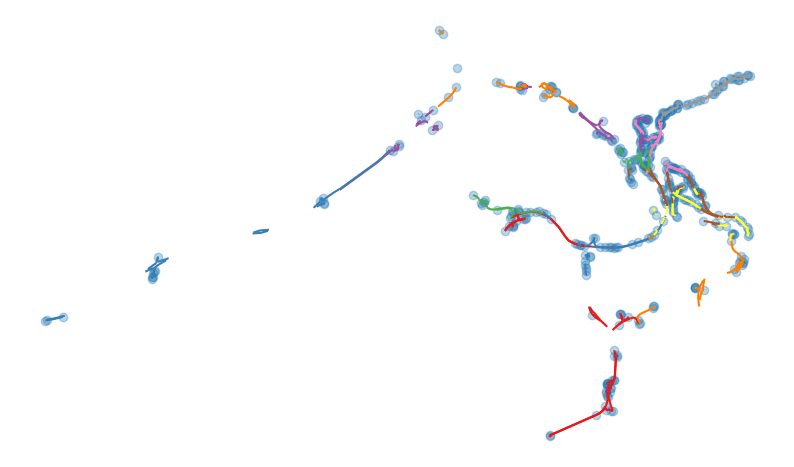

In [31]:
# merging lines between nodes to keep:

tiny_buffers = nodes_boundary[nodes_boundary.to_keep].buffer(0.01).union_all()

# make queen contiguity graph on MINUSBUFFERED outline road segments, 
# and copy component labels into edge_outside gdf
queen = graph.Graph.build_contiguity(
    edges_outside.difference(tiny_buffers), 
    rook=False
)
edges_outside["comp"] = queen.component_labels

# plot to see if it worked
fig, ax = plt.subplots(1,1, figsize = (10,10))
edges_outside.plot(column="comp", ax=ax, cmap = "Set1")
nodes_boundary[nodes_boundary.to_keep].plot(ax=ax, alpha = .3)
ax.set_axis_off()

In [33]:
%%time
skel, _ = voronoi_skeleton( # this is the one we need
    edges_outside.dissolve(by="comp").geometry,
    cluster_geom
)


In [ ]:
%%time
# skeletonize twice (just to compare: with and without interstitial node removal)
skel_full, _ = voronoi_skeleton( # this is the superfluous one
    edges_outside.geometry,
    cluster_geom
)


In [ ]:
### plot to see if all is correct
fig, ax = plt.subplots(1,1, figsize =(20,40))

# plot the entire street network
roads.iloc[roads.sindex.query(cluster_geom, predicate="intersects")].plot(ax=ax, alpha = .1)

# plot the artifact cluster
artifacts[artifacts.comp == mycomp].plot(ax=ax, alpha = .1, zorder = 0)

# plot artifact boundary 
edges_outside.plot(ax=ax, color = "grey", zorder = 1)

#edges_within.plot(ax=ax, color = "grey", alpha = .1, zorder = 2)

# plot nodes to keep
nodes_boundary[nodes_boundary.to_keep].plot(
    ax=ax, zorder = 3, markersize = 15, color = "red"
)

# plot skeletonization (=new edges WITHIN artifact cluster)
gpd.GeoSeries(skel).plot(ax=ax, color = "black", lw = 1, linestyle = "dotted")

# plot superfluous skeletonization (the above one is a subset of this)
gpd.GeoSeries(skel_full).plot(ax=ax, color = "grey", lw = 4, zorder = 0, alpha = .2)

ax.set_axis_off()

*instructions on which above was based*

find nodes that 

* have degree n 
* on the boundary of cluster_geom
* intersect n-2 orange

if remove before skel:
* linemerged boundary minus nodes-to-keep plus tiny buffer gives sequences of road segments to merge
* create queen contiguity graph on roads segments minus tiny buffers, from there component label that assigns to original segments pre-bufferlip
* dissolve
* pass as input for skel

if remove after skel:
* remove lines from skelet that intersect these nodes, then remove dangles